In [1]:
! pip install optuna  scikit-learn gensim imbalanced-learn xgboost torch pandas matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 13.5 MB/s eta 0:00:00


In [1]:
 #Import All Libraries Here
import pandas as pd
from sklearn.metrics import accuracy_score ,  roc_curve, auc , classification_report

import numpy as np
from sklearn.metrics import classification_report, accuracy_score

from sklearn.metrics import mean_squared_error
import optuna
from torch.utils.data import WeightedRandomSampler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
import time
from collections import Counter
# PyTorch Import

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F


WINDOW_SIZE = 50

# 1 - One Hot Encoding with Pytorch in build Emnedding
# 2 - 3-mer coding with number encoding
ENCODING_METHOD = 2

# 1- Random Over Sampling
# 2 - Weighted Over Sampler
SAMPLING_METHOD =1

# 1 - LSTM with Cross Entropy
MODEL = 1


FRAMEWORK = "PYTORCH"

# Startegy to Crop Sequene
# MID - Modification is present at Mid of cropped Sequence
# END - Modification is present at End of cropepd Sequence
CROP_STRATEGY = 'MID'

# Y Category Encoding Method
# LABEL or ONE_HOT
TARGET_ENCODING = 'LABEL'

ENCODING_FILE = '3-mer-dictionary.pkl'

c:\Users\shashi.vish\Python Environment\RNA_ModX\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

# from google.colab import drive
# drive.mount('/content/drive')
# INPUT_TRAIN_IN = "/content/drive/My Drive/Colab Notebooks/Capstone Project/data/train_in.csv"
# INPUT_TRAIN_OUT = "/content/drive/My Drive/Colab Notebooks/Capstone Project/data/train_out.csv"
# INPUT_TEST_IN = "/content/drive/My Drive/Colab Notebooks/Capstone Project/data/test_in.csv"
# INPUT_TEST_OUT = "/content/drive/My Drive/Colab Notebooks/Capstone Project/data/test_out.csv"
# INPUT_VALIDATION_IN = "/content/drive/My Drive/Colab Notebooks/Capstone Project/data/valid_in_nucleo.csv"
# INPUT_VALIDATION_OUT  = "/content/drive/My Drive/Colab Notebooks/Capstone Project/data/valid_out.csv"

# Record Constants
# Record Constants
INPUT_TRAIN_IN = "../../../data/train_in.csv"
INPUT_TRAIN_OUT = "../../../data/train_out.csv"
INPUT_TEST_IN = "../../../data/test_in.csv"
INPUT_TEST_OUT = "../../../data/test_out.csv"
INPUT_VALIDATION_IN = "../../../data/valid_in_nucleo.csv"
INPUT_VALIDATION_OUT  = "../../../data/valid_out.csv"

# TARGET_MODEL_PATH = '../../webapp/model_files'




In [3]:
#Read X Varaibles and Y Varaibles

x_train_raw =  pd.read_csv(INPUT_TRAIN_IN, header=None , skiprows=1 )
y_train_raw =  pd.read_csv(INPUT_TRAIN_OUT, header=None , skiprows=1 )

x_test_raw =  pd.read_csv(INPUT_TEST_IN, header=None , skiprows=1 )
y_test_raw =  pd.read_csv(INPUT_TEST_OUT, header=None , skiprows=1)

x_valid_raw =  pd.read_csv(INPUT_VALIDATION_IN, header=None , skiprows=1 )
y_valid_raw =  pd.read_csv(INPUT_VALIDATION_OUT, header=None , skiprows=1 )

x_data = pd.concat([x_train_raw, x_test_raw, x_valid_raw], axis=0, ignore_index=True)
y_data = pd.concat([y_train_raw, y_test_raw, y_valid_raw], axis=0, ignore_index=True)

print(f"Train Shape of X : {x_train_raw.shape} and Tranin Shape of Y : {x_train_raw.shape}")
print(f"Test Shape of X : {x_test_raw.shape} and Test Shape of Y : {y_test_raw.shape}")
print(f"Validation Shape of X : {x_valid_raw.shape} and Validation Shape of Y : {y_valid_raw.shape}")


Train Shape of X : (304661, 1001) and Tranin Shape of Y : (304661, 1001)
Test Shape of X : (1200, 1001) and Test Shape of Y : (1200, 12)
Validation Shape of X : (3599, 1001) and Validation Shape of Y : (3599, 12)


### Calculate Sequence Positions to extracted from Original Sequence

In [4]:
middle_index = (x_train_raw.shape[1] // 2) + 1 # This is location for Modified Sequence . Use this as Y Target

if CROP_STRATEGY == 'MID':
    STRAT_INEDX =middle_index - WINDOW_SIZE -1
    END_INDEX =middle_index + WINDOW_SIZE

if CROP_STRATEGY == 'END':
    STRAT_INEDX =middle_index - (WINDOW_SIZE*2) -1
    END_INDEX =middle_index

x_data_cropped =  x_data.iloc[:,STRAT_INEDX :END_INDEX]
concatenated_column= x_data_cropped.apply(lambda row: ''.join(map(str, row)), axis=1)
x_data_cropped = x_data_cropped.assign(Sequence=concatenated_column)

In [5]:
x_data_cropped

,450,451,452,453,454,455,456,457,458,459,...,542,543,544,545,546,547,548,549,550,Sequence
0,T,T,G,C,C,A,C,A,C,T,...,C,A,G,T,A,T,C,T,C,TTGCCACACTGCTGGACGCCTGCAAGGCCAAGGGTACGGAGGTCAT...
1,T,T,T,G,A,A,A,A,A,A,...,T,C,A,T,C,G,T,G,C,TTTGAAAAAATATTAGCAATGTGAGGACACTTAAGCAGTTTTGTCA...
2,A,G,A,A,A,C,A,T,T,C,...,T,T,C,T,G,T,T,C,A,AGAAACATTCAACCTCCCTTCTTTTTATTCCAGTTGTCCTTTTCTC...
3,T,T,A,G,T,T,T,T,A,C,...,A,A,A,A,A,T,T,T,C,TTAGTTTTACTATGGAATCATAATAACCCACATAGAAGACTGATAT...
4,C,A,A,C,A,G,A,A,G,T,...,A,A,A,A,T,G,T,A,C,CAACAGAAGTTTCTCATCTATAATCAGTAGCACTAAACTCTTGGTT...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309455,C,C,A,A,A,C,T,C,T,T,...,G,G,G,C,A,G,A,G,A,CCAAACTCTTTATCTCTTGAGTTCTCAGCCAATAGGGCCATTGTAG...
309456,G,A,T,C,C,A,G,T,T,G,...,A,C,A,G,G,T,A,A,T,GATCCAGTTGAAAACGTATCCCTCTACTTTCTTCAGTTGTAGAAAA...
309457,G,C,C,A,G,G,G,C,A,A,...,C,A,A,G,C,T,G,A,T,GCCAGGGCAAAGCTGGCTGATTTTACGTGTTTAAGGATGAAATATC...
309458,C,T,G,G,G,T,G,C,G,A,...,G,C,A,G,A,G,T,C,A,CTGGGTGCGACAGGCCACTGGACAAGGGCTTGAGTGGATGGGATGG...


In [6]:
x_train_raw = None
y_train_raw = None
x_test_raw = None
y_test_raw = None
x_valid_raw = None
y_valid_raw = None

### Apply One Hot Encoding

In [7]:
number_of_unique_kmers = set()
def encode_seq(kmer_token):

    # A 1 0 0 0
    # C 0 1 0 0
    # T/U 0 0 0 1
    # G 0 0 1 0
    # N 0 0 0 0

    encoding_dict = {
        'A': [1, 0, 0, 0],
        'C': [0, 1, 0, 0],
        'G': [0, 0, 1, 0],
        'T': [0, 0, 0, 1],
        'U': [0, 0, 0, 1],
        'N': [0, 0, 0, 0],
    }

    encoded_sequence = []
    number_of_unique_kmers.add(kmer_token)
    for  base in kmer_token:
        encoded_sequence.append(encoding_dict[base])
    return np.array(encoded_sequence).flatten()

def applyOneHotEncoding(tokenized_sequences):
    encoded_sequences = []
    for seq in tokenized_sequences:
        encoded_sequences.append(encode_seq(seq))

    return np.array(encoded_sequences).flatten()

def encode_with_one_hot_encoding(x_train_raw):
    truncated_df =  x_train_raw.iloc[:,STRAT_INEDX :END_INDEX] # Window Starts from V501 with 50 window size
    concatenated_column= truncated_df.apply(lambda row: ''.join(map(str, row)), axis=1)
    df_result = truncated_df.assign(Sequence=concatenated_column)
    tokenized_sequences =  df_result['Sequence'].apply(applyOneHotEncoding).tolist()

    return tokenized_sequences


### 3 mer coding

In [86]:
import pickle

kmer_dict = {}
k = 3
with open(ENCODING_FILE, 'rb') as f:
    kmer_dict = pickle.load(f)


def encode_with_k_mer_codon(sequence):
    #print(sequence)
    encoded_sequence = []
    for i in range(len(sequence) - k + 1):
        if sequence[i:i+k] not in kmer_dict:
            print("Key Not Found" , kmer_dict)
        encoded_sequence.append(kmer_dict[sequence[i:i+k]] )
    return np.array(encoded_sequence)

In [99]:
## Filter Dataset to Keep only Target Binary Class

RMs = ['hAm','hCm','hGm','hTm','hm1A','hm5C','hm5U','hm6A','hm6Am','hm7G','hPsi','Atol','NonMoD']
RMEncoding = [12,1,2,3,4,5,6,7,8,9,10,11,0]

eligible_class_list = ['hGm', 'hm7G']
ARMEncoding = [0,1]

def convert_y_to_original_labels(row):
    label = ""  
    for index , n in enumerate(row.tolist()) :
        if n == 1 :
            label = RMs[index]
    if label == '':
        return 'NonMoD'
    return label

def get_original_y_lables( y_data ):
    # Convert One Hot Encoded Y to to Original Labels
    y_original_labels = y_data.apply(convert_y_to_original_labels,axis=1)
    return y_original_labels



def encode_target(y_data):
    # Write Customer Lable Encoder . This is required since we have train and test alreday splitted. Always creating a new instanc of label encoder will change encoding.

    y_encoded = []
    for y in y_data:
        index = eligible_class_list.index(y)
        encoding =  ARMEncoding[index]
        y_encoded.append(encoding)
    return y_encoded

def prepare_data_for_binary_classification(x_data , y_data , prediction_class):
    # Convert One Hot Encoded Y to to Original Labels
    y_original_labels = y_data.apply(convert_y_to_original_labels,axis=1)
    x_data['Label'] = y_original_labels

    selected_rna_data = x_data[x_data['Label'].isin(prediction_class)]

    y_filtered = selected_rna_data['Label']
    x_filtered = selected_rna_data.drop('Label', axis=1)

    return x_filtered , y_filtered

In [100]:

x_data_filtered , y_data_filtered = prepare_data_for_binary_classification(x_data_cropped , y_data , eligible_class_list)


In [110]:
x_data_filtered

,450,451,452,453,454,455,456,457,458,459,...,542,543,544,545,546,547,548,549,550,Sequence
2782,T,T,T,T,A,A,C,A,C,A,...,T,T,T,T,T,T,T,G,A,TTTTAACACAATACTTTAATAAGACACATTTAAACTCAACTTCTGA...
2783,C,C,T,T,T,G,G,G,G,G,...,A,A,C,A,G,A,T,C,T,CCTTTGGGGGGCTAATAGCTCCTATATTCATTCAAAGAAGGAATAG...
2784,G,G,C,G,C,A,G,G,G,A,...,G,G,A,T,A,T,T,T,A,GGCGCAGGGAAGAGGAAGCGGAGGCACTCGGAAGGTAAGTGGCTAG...
2785,A,A,T,T,A,T,T,T,T,T,...,C,G,A,G,A,C,C,A,T,AATTATTTTTTTAGGGCCGGGCGCGGTGGCTCACGTCTGTAATCCC...
2786,T,G,T,A,T,T,T,T,T,C,...,A,T,T,T,C,T,T,G,C,TGTATTTTTCATGTATGGCCTTTATCATGTTGAGTAAGTTTCTTTC...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,T,C,T,G,T,T,G,T,C,A,...,G,T,C,T,G,A,T,T,T,TCTGTTGTCATCCTATCATTGACCTGAGATACCAGAGATCGCCAAA...
307507,G,G,A,A,A,G,A,G,A,A,...,T,G,T,G,C,A,G,A,G,GGAAAGAGAACACACACCCCAGGTGTCATGCACACCCTCGGAAGAC...
307508,T,T,T,G,G,A,A,A,A,A,...,A,G,A,G,G,G,C,C,A,TTTGGAAAAAGAGATATCCTAGCTCAGGGCAAGCCGTTTGATGGAA...
307509,T,T,C,A,A,G,C,G,A,T,...,C,A,G,G,G,T,T,T,C,TTCAAGCGATTCTCCTGCCTCAGCCTCCCGAGTAGCTGGGATTACA...


In [101]:
y_data_filtered.value_counts()

hm5C    3207
hCm     1878
Name: Label, dtype: int64

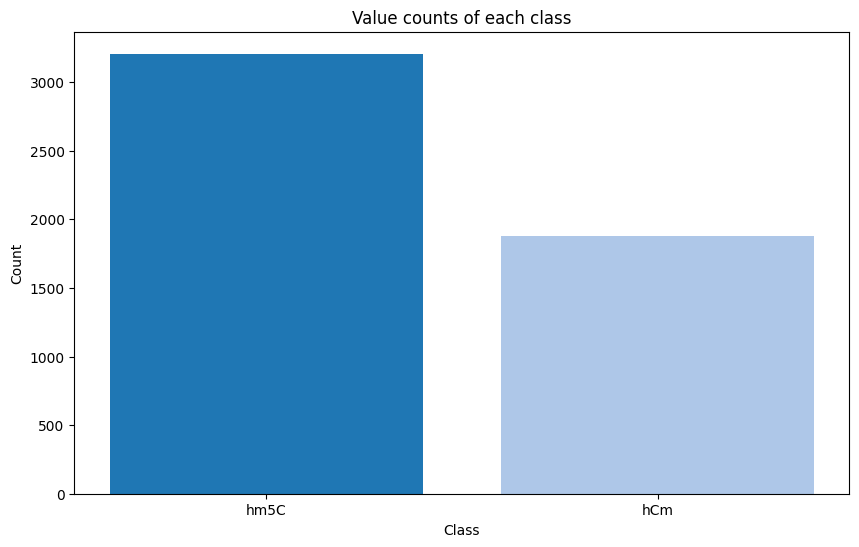

In [109]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

y_counts = y_data_filtered.value_counts()
colors = cm.tab20(range(len(y_counts)))
plt.figure(figsize=(10, 6))
plt.bar(y_counts.index, y_counts.values , color = colors)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Value counts of each class')
plt.show()

In [91]:
x_data_filtered['Sequence']

6138      AGAGCAAGACCCTGTCTCAAAAAAAAAAAAAGATACACACACACAA...
6139      AGCAAACACATCCTTCTACACATGGCAGCAGGAGACAAGTGCCAAG...
6140      AGTTGCTTATTCCAGTAACTGTGCTGTTCCACTCTCCCTCTTTCCT...
6141      TTAGAATAATAATCTGGATCACTGAGTTGGGAGAGAGACTCTCAGT...
6142      GCTCTTTTTTTTCCTTTTGAGATGGAATTTCGCTCTTGTTACCCCA...
                                ...                        
308706    GGTATGGTGGCTCATGCCTATAATCCCAGCACTTTGGGAGGCCGAG...
308707    GCCTGCTTCAGCCAGAGGCCTGCAGCGCCTTCTGCTTCTCCACCGG...
308708    GACGGACTCATCTTTGGAACAGGAACCATGGACTCTCAGATCAAGA...
308709    GAGGCCTACCCATAATCCAGAGAGGCTTGCCCAGAGGAGGACTACG...
308710    GTTCGCGACCCGAGGGGACCGCGGGGGCTGAGGGGAGGGGCCGCGG...
Name: Sequence, Length: 2507, dtype: object

In [106]:
encoded_sequences = [encode_with_k_mer_codon(sequence) for sequence in x_data_filtered['Sequence']]
X_encoded = np.array(encoded_sequences)
X_encoded_tensor = torch.tensor(X_encoded, dtype=torch.float32)
y_encoded = encode_target(y_data_filtered)

In [107]:
X_encoded_tensor

tensor([[50., 50., 62.,  ..., 50., 35., 52.],
        [ 6., 42., 50.,  ..., 55., 12., 22.],
        [17., 44., 30.,  ..., 61., 50., 62.],
        ...,
        [50., 35., 45.,  ..., 17., 29.,  1.],
        [43., 11., 60.,  ..., 34., 50., 43.],
        [25., 52., 39.,  ...,  1.,  2., 33.]])

In [108]:
print("Generate Train and Split..")
# Train set
X_train, X_temp, y_train, y_temp = train_test_split(X_encoded, y_encoded, test_size=0.3, random_state=42)

# Test and Validation set
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


Generate Train and Split..


In [111]:
X_encoded = None
y_encoded = None
x_data_filtered , y_data_filtered = None,None
x_data , y_data = None , None

print("Train Y Count : " ,Counter(y_train))
print("Test Y Count : " ,Counter(y_test))


Train Y Count :  Counter({0: 2266, 1: 1293})
Test Y Count :  Counter({0: 457, 1: 306})


### Balance Datset

In [112]:
y_train = torch.tensor(y_train , dtype=torch.long)
y_test = torch.tensor(y_test , dtype=torch.long)
y_valid = torch.tensor(y_valid , dtype=torch.long)

sm = RandomOverSampler(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)
y_resampled = torch.tensor(y_resampled , dtype=torch.float32) # Keeping float32
X_resampled = torch.tensor(X_resampled , dtype=torch.float32)

In [17]:
print(X_train.shape)
print(y_train.shape)

torch.Size([96722, 99])
torch.Size([96722])


In [113]:
X_resampled[1]

tensor([54., 61., 43., 22., 42., 62., 32., 12., 13.,  1.,  2., 61., 43., 22.,
        25., 28., 29.,  1.,  2., 61., 43., 22., 25., 28., 18.,  2., 12., 13.,
         6., 42., 50., 62., 47., 48.,  9., 27., 45., 51., 53., 59., 37.,  2.,
        61., 50., 62.,  8., 20., 17., 29.,  1.,  2., 61., 50., 62., 32.,  3.,
        32., 61., 43., 11., 60., 59., 37.,  2., 61., 62.,  8.,  9., 46., 32.,
        61., 35., 52., 53., 63., 63., 48.,  9., 27., 52., 39., 20., 21., 46.,
         4., 58., 14., 22., 42., 43., 22.,  7., 32., 61., 43., 11., 36., 58.,
        25.])

In [122]:
hyperparameter = {}
hyperparameter['INPUT_DIMENSION'] = len(kmer_dict) # For One Hot Encoding Input Dimension would be 4 as there only 4 unique nucleocide
hyperparameter['HIDDEN_DIMENSION'] = 32
hyperparameter['NO_OF_LAYERS'] = 2
hyperparameter['BATCH_SIZE'] = 32
hyperparameter['OUTPUT_DIMENSION'] = len(eligible_class_list)
hyperparameter['EMBEDDING_DIMENSION'] = 16 # if you are using Word2Vec Encoding then this should be same as Word2Vec Embedding Dim
hyperparameter['DROP_OUT'] = 0.1
hyperparameter['LEARNING_RATE'] = 0.0001


class RNADataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

train_dataset = RNADataset(X_resampled, y_resampled)
test_dataset = RNADataset(X_test, y_test)
valid_dataset = RNADataset(X_valid, y_valid)


train_dataloader = DataLoader(train_dataset, batch_size=hyperparameter['BATCH_SIZE'], shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size=hyperparameter['BATCH_SIZE'], shuffle=False)
valid_dataloader = DataLoader(valid_dataset, batch_size=hyperparameter['BATCH_SIZE'], shuffle=False)

In [115]:
import torch.nn as nn

class RNATransformerModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, num_layers, output_dim, dropout=0.5):
        super(RNATransformerModel, self).__init__()

        self.embedding = nn.Embedding(input_dim, embedding_dim)

        # If batch size first is true then it should be batch size , sequence lenght , embedding dimension
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=8, dim_feedforward=hidden_dim , batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)

        self.fc = nn.Linear(embedding_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = x.long()
        #print("Shape of Original X  ", x.shape)
        x_embedded = self.embedding(x)
        #print("Shape of X embedded" , x_embedded.shape)
        x_transformed = self.transformer_encoder(x_embedded)
        #print("Shape of Transformed X" , x_transformed.shape)
        x_transformed = x_transformed[:, -1, :]  # taking the last token's output

        output = self.dropout(x_transformed)
        out = self.fc(output)
        return out

In [116]:
# Check data is in correct shape - batch size , sequece len , embedding dimension size
for inputs, labels in train_dataloader:
    print(inputs.shape)
    break

torch.Size([32, 99])


In [117]:
import torch.optim.lr_scheduler as lr_scheduler


def validate_model(model, test_dataloader , device ,loss_function):
    model.eval()
    running_loss = 0.0
    class_correct = [0] * hyperparameter['OUTPUT_DIMENSION']
    class_total = [0] * hyperparameter['OUTPUT_DIMENSION']
    total = 0
    correct = 0
    true_labels = []
    predicted_labels = []

    with torch.inference_mode():
        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.long().to(device)

            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            true_labels.extend(labels.cpu().numpy())  # Capture True Lables for Summary Report
            predicted_labels.extend(predicted.cpu().numpy()) # Capture Predicted Labels Lables for Summary Report

    validation_loss = running_loss / len(test_dataloader)
    validation_accuracy = correct / total

    return validation_loss , validation_accuracy , true_labels , predicted_labels


def train_model(model, train_dataloader, test_dataloader, device, epochs, optimizer, loss_function):
    best_val_loss = float('inf')
    no_improvement_count = 0
    scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5) 

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        start_time = time.time()

        for i, (inputs, labels) in enumerate(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.long().to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_dataloader)
        val_loss,  validation_accuracy , true_labels , predicted_labels = validate_model(model, test_dataloader, device, loss_function)
        end_time = time.time()
        elapsed_time = end_time - start_time

        print(f"Epoch {epoch + 1}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Test Accuracy: {validation_accuracy:.4f} ,Learning Rate: {optimizer.param_groups[0]['lr']} , Time Taken : {elapsed_time}")

        scheduler.step()

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            no_improvement_count = 0
        else:
            no_improvement_count += 1
            if no_improvement_count == 5:
                print("No improvement in validation loss for 5 epochs. Training stopped.")
                break



In [123]:
model = RNATransformerModel(input_dim=hyperparameter['INPUT_DIMENSION'],
                            embedding_dim=hyperparameter['EMBEDDING_DIMENSION'],
                            hidden_dim=hyperparameter['HIDDEN_DIMENSION'] ,
                            num_layers = hyperparameter['NO_OF_LAYERS'],
                            output_dim=hyperparameter['OUTPUT_DIMENSION'],
                            dropout=hyperparameter['DROP_OUT'] )


loss_function = nn.CrossEntropyLoss()  ## MSELoss of Regression problem  # BCELoss for binary classification
optimizer = optim.Adam(model.parameters() ,  lr=hyperparameter['LEARNING_RATE'])

# Number of Parameters for Model
total_parameters = []
for p in model.parameters():
    total_parameters.append(p.numel())

print(f"Total Number of Parameters for Model Training : { sum(total_parameters)} " )

# Train the model
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print("Model Parameters  : " , hyperparameter)

# Train Model with configured Parameter
train_model(model, train_dataloader ,test_dataloader, device ,num_epochs,optimizer,loss_function)

Total Number of Parameters for Model Training : 14882 
Model Parameters  :  {'INPUT_DIMENSION': 94, 'HIDDEN_DIMENSION': 32, 'NO_OF_LAYERS': 2, 'BATCH_SIZE': 32, 'OUTPUT_DIMENSION': 2, 'EMBEDDING_DIMENSION': 16, 'DROP_OUT': 0.1, 'LEARNING_RATE': 0.0001}
Epoch 1, Train Loss: 0.7474, Val Loss: 0.7315, Test Accuracy: 0.4626 ,Learning Rate: 0.0001 , Time Taken : 19.985374927520752
Epoch 2, Train Loss: 0.7155, Val Loss: 0.7080, Test Accuracy: 0.4823 ,Learning Rate: 0.0001 , Time Taken : 20.00195574760437
Epoch 3, Train Loss: 0.7049, Val Loss: 0.7094, Test Accuracy: 0.4626 ,Learning Rate: 0.0001 , Time Taken : 20.482758045196533
Epoch 4, Train Loss: 0.7026, Val Loss: 0.7014, Test Accuracy: 0.4731 ,Learning Rate: 0.0001 , Time Taken : 20.425384283065796
Epoch 5, Train Loss: 0.7015, Val Loss: 0.6957, Test Accuracy: 0.4902 ,Learning Rate: 0.0001 , Time Taken : 20.11075448989868
Epoch 6, Train Loss: 0.7030, Val Loss: 0.6977, Test Accuracy: 0.4836 ,Learning Rate: 5e-05 , Time Taken : 19.8353223800

### Optuna Hyperparameter Optimization

In [ ]:
import optuna

def objective(trial):
    hyperparameter = {}
    hyperparameter['INPUT_DIMENSION'] = len(kmer_dict)
    hyperparameter['HIDDEN_DIMENSION'] = trial.suggest_int('HIDDEN_DIMENSION', 16, 128)
    hyperparameter['NO_OF_LAYERS'] = trial.suggest_int('NO_OF_LAYERS', 1, 4)
    hyperparameter['BATCH_SIZE'] = trial.suggest_categorical('BATCH_SIZE', [16, 32, 64])
    hyperparameter['OUTPUT_DIMENSION'] = 5
    hyperparameter['EMBEDDING_DIMENSION'] = 16  # Adjust as needed
    hyperparameter['DROP_OUT'] = trial.suggest_float('DROP_OUT', 0.1, 0.5)
    hyperparameter['LEARNING_RATE'] = trial.suggest_loguniform('LEARNING_RATE', 1e-5, 1e-3)

    model = RNATransformerModel(input_dim=hyperparameter['INPUT_DIMENSION'],
                                embedding_dim=hyperparameter['EMBEDDING_DIMENSION'],
                                hidden_dim=hyperparameter['HIDDEN_DIMENSION'],
                                num_layers=hyperparameter['NO_OF_LAYERS'],
                                output_dim=hyperparameter['OUTPUT_DIMENSION'],
                                dropout=hyperparameter['DROP_OUT'])

    model = model.to(device)

    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=hyperparameter['LEARNING_RATE'])

    train_dataloader = DataLoader(train_dataset, batch_size=hyperparameter['BATCH_SIZE'], shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=hyperparameter['BATCH_SIZE'], shuffle=False)
    valid_dataloader = DataLoader(valid_dataset, batch_size=hyperparameter['BATCH_SIZE'], shuffle=False)


    train_model(model, train_dataloader ,test_dataloader, device ,num_epochs,optimizer,loss_function)

    _, final_accuracy, true_labels, predicted_labels = validate_model(model, valid_dataloader,device,loss_function)

    return final_accuracy


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

    # Print the result
trial = study.best_trial
print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

In [124]:
# Evaluate the model on the test dataset
_, final_accuracy, true_labels, predicted_labels = validate_model(model, valid_dataloader,device,loss_function)

# Print the final accuracy
print(f"Final Accuracy: {final_accuracy:.4f}")

# Print the classification summary
print("\n Classification Summary:")
print(classification_report(true_labels, predicted_labels))

Final Accuracy: 0.5229

 Classification Summary:
              precision    recall  f1-score   support

           0       0.65      0.53      0.59       484
           1       0.38      0.51      0.44       279

    accuracy                           0.52       763
   macro avg       0.52      0.52      0.51       763
weighted avg       0.55      0.52      0.53       763

